In [24]:
!pip install joblib
!pip install openpyxl

In [9]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
import random
import networkx as nx
import tensorflow_probability as tfp
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.trajectories import trajectory
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed

## 데이터 준비

In [2]:
# 현재 디렉토리를 사용
directory_path = '.'

# 파일명과 DataFrame/을 저장할 딕셔너리
csv_dataframes = {}

# 해당 경로 내 모든 파일을 확인하여 CSV 파일을 읽어들임
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        # 파일명을 사용하여 DataFrame으로 저장 (확장자 제거)
        df_name = os.path.splitext(filename)[0]
        # CSV 파일을 읽어서 DataFrame으로 저장
        csv_dataframes[df_name] = pd.read_csv(file_path,encoding='cp949')

In [3]:
csv_dataframes

{'customer_info_grouped.ver2':         Unnamed: 0    tck_iem_cd    bse_dt  cus_cgr_llf_cd  cus_cgr_mlf_cd  \
 0                0  AA            20240528        2.181818       24.363636   
 1                1  AA            20240529        2.181818       24.363636   
 2                2  AA            20240530        2.181818       24.363636   
 3                3  AA            20240531        2.181818       24.363636   
 4                4  AA            20240603        2.181818       24.363636   
 ...            ...           ...       ...             ...             ...   
 150981      150981  ZYXI          20240820        2.000000       22.000000   
 150982      150982  ZYXI          20240821        2.000000       22.000000   
 150983      150983  ZYXI          20240822        2.000000       22.000000   
 150984      150984  ZYXI          20240823        2.000000       22.000000   
 150985      150985  ZYXI          20240826        2.000000       22.000000   
 
         cus_cgr_act

In [4]:
NH_OFW_daily_info = csv_dataframes['NH_CONTEST_NHDATA_IFW_OFW_IFO']
NH_Customer_info = csv_dataframes['NH_CONTEST_NHDATA_CUS_TP_IFO']
ETF_div = csv_dataframes['NH_CONTEST_DATA_HISTORICAL_DIVIDEND']
ETF_score_info = csv_dataframes['NH_CONTEST_ETF_SOR_IFO']
Stock_price_by_day = csv_dataframes['NH_CONTEST_STK_DT_QUT']
ETF_info = csv_dataframes['NH_CONTEST_DATA_ETF_HOLDINGS']
Overseas_stock_info=csv_dataframes['NH_CONTEST_NW_FC_STK_IEM_IFO']
NH_Stock_daily_info = csv_dataframes['NH_CONTEST_NHDATA_STK_DD_IFO']

## ETF 리밸런싱 자동화 시스템

In [6]:
# 컬럼명 변경 (etf_iem_cd -> etf_tck_cd)
ETF_score_info.rename(columns={'etf_iem_cd': 'etf_tck_cd'}, inplace=True)

# 공백 제거
ETF_score_info['etf_tck_cd'] = ETF_score_info['etf_tck_cd'].apply(lambda s: s.strip())
ETF_info['etf_tck_cd'] = ETF_info['etf_tck_cd'].apply(lambda s: s.strip())

# 'etf_tck_cd' 기준으로 left join 수행
merged_df = pd.merge(ETF_score_info, ETF_info, how='left', on='etf_tck_cd')
merged_df =merged_df.dropna()
merged_df

,bse_dt,etf_tck_cd,mm1_tot_pft_rt,mm3_tot_pft_rt,yr1_tot_pft_rt,etf_sor,etf_z_sor,z_sor_rnk,acl_pft_rt_z_sor,ifo_rt_z_sor,...,trk_err_z_sor,mxdd_z_sor,vty_z_sor,tck_iem_cd,mkt_vlu,fc_sec_eng_nm,fc_sec_krl_nm,stk_qty,wht_pct,sec_tp
62,20240717,CIBR,6.1196,8.8162,28.1019,48.240248,65.957447,385,77.659574,81.648936,...,83.599291,47.429078,17.819149,BB,18370666.0,BlackBerry Ltd.,블랙베리,8465745.0,0.284,ST
63,20240717,CIBR,6.1196,8.8162,28.1019,48.240248,65.957447,385,77.659574,81.648936,...,83.599291,47.429078,17.819149,-,17080793.0,US Dollar,-,17080794.0,0.264,-
64,20240717,CIBR,6.1196,8.8162,28.1019,48.240248,65.957447,385,77.659574,81.648936,...,83.599291,47.429078,17.819149,RDWR,16134232.0,Radware Ltd.,-,751478.0,0.249,ST
65,20240717,CIBR,6.1196,8.8162,28.1019,48.240248,65.957447,385,77.659574,81.648936,...,83.599291,47.429078,17.819149,ATEN,13166366.0,"A10 Networks, Inc.",A10 네트웍스,1038357.0,0.203,ST
66,20240717,CIBR,6.1196,8.8162,28.1019,48.240248,65.957447,385,77.659574,81.648936,...,83.599291,47.429078,17.819149,-,-133.0,Canadian Dollar,-,-183.0,0.000,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717101,20240621,VYM,-1.3991,2.3230,15.4013,41.044025,44.833783,615,39.173405,36.477987,...,21.563342,55.795148,77.088949,HON,561997775.0,Honeywell International Inc.,하니웰,2631815.0,0.845,ST
717102,20240621,VYM,-1.3991,2.3230,15.4013,41.044025,44.833783,615,39.173405,36.477987,...,21.563342,55.795148,77.088949,UNP,557617543.0,Union Pacific Corp.,유니온 퍼시픽,2464499.0,0.838,ST
717103,20240621,VYM,-1.3991,2.3230,15.4013,41.044025,44.833783,615,39.173405,36.477987,...,21.563342,55.795148,77.088949,T,554191853.0,AT&T Inc.,AT&T,29000097.0,0.833,ST
717104,20240621,VYM,-1.3991,2.3230,15.4013,41.044025,44.833783,615,39.173405,36.477987,...,21.563342,55.795148,77.088949,COP,541508433.0,ConocoPhillips,코노코필립스,4734293.0,0.814,ST


In [7]:
merged_df.isnull().sum()

bse_dt              0
etf_tck_cd          0
mm1_tot_pft_rt      0
mm3_tot_pft_rt      0
yr1_tot_pft_rt      0
etf_sor             0
etf_z_sor           0
z_sor_rnk           0
acl_pft_rt_z_sor    0
ifo_rt_z_sor        0
shpr_z_sor          0
crr_z_sor           0
trk_err_z_sor       0
mxdd_z_sor          0
vty_z_sor           0
tck_iem_cd          0
mkt_vlu             0
fc_sec_eng_nm       0
fc_sec_krl_nm       0
stk_qty             0
wht_pct             0
sec_tp              0
dtype: int64

In [8]:
# 불필요한 컬럼 제거
columns_to_keep = [
    'etf_tck_cd', 'mm1_tot_pft_rt', 'mm3_tot_pft_rt', 'yr1_tot_pft_rt',
    'etf_sor', 'etf_z_sor', 'z_sor_rnk', 'acl_pft_rt_z_sor', 'ifo_rt_z_sor',
    'shpr_z_sor', 'crr_z_sor', 'trk_err_z_sor', 'mxdd_z_sor', 'vty_z_sor'
]

# 필요한 컬럼만 남기고 데이터프레임 재구성
filtered_df = merged_df[columns_to_keep]

In [ ]:
class ETFRebalancingEnv(py_environment.PyEnvironment):
    """TensorFlow 기반 강화 학습을 사용한 ETF 리밸런싱을 위한 사용자 정의 환경"""
    
    def __init__(self, etf_data):
        # 'etf_tck_cd' 열을 더미 변수로 변환하여 각 ETF를 고유하게 표현
        etf_data = pd.get_dummies(etf_data, columns=['etf_tck_cd'])
        # 불필요한 열인 'fc_sec_eng_nm', 'fc_sec_krl_nm'은 제거
        etf_data = etf_data.drop(columns=['fc_sec_eng_nm', 'fc_sec_krl_nm'], errors='ignore')

        # 환경 초기화
        self._etf_data = etf_data
        self._current_step = 0  # 현재 스텝
        self._portfolio_value = 100000  # 초기 포트폴리오 가치
        self._previous_portfolio_value = 100000  # 이전 포트폴리오 가치
        self._max_portfolio_value = 1e6  # 포트폴리오 최대값 설정
        self._min_portfolio_value = 1e4  # 포트폴리오 최소값 설정

        # 티커별로 포트폴리오 비중 기록을 위한 초기화
        self.ticker_history = {ticker: [] for ticker in etf_data.columns}

        # 행동(action) 및 관측(observation) 공간 정의
        # 행동: 0~4 사이의 정수로 정의 (예: 각 행동은 포트폴리오 내 ETF 비중에 대한 전략)
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=4, name='action')
        # 관측: ETF 데이터의 차원에 맞게 정의 (float32로 된 관측값)
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(etf_data.shape[1],), dtype=np.float32, minimum=-np.inf, maximum=np.inf, name='observation')

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        # 환경을 초기화하여 첫 번째 관측값을 반환
        self._current_step = 0
        self._portfolio_value = 100000
        self._previous_portfolio_value = 100000
        observation = self._etf_data.iloc[self._current_step].values.astype(np.float32)
        return ts.restart(observation)

    def _step(self, action):
        # 마지막 스텝에 도달한 경우 종료
        if self._current_step >= len(self._etf_data) - 1:
            observation = self._etf_data.iloc[self._current_step].values.astype(np.float32)
            return ts.termination(observation, reward=0)

        # 행동(action)에 따라 ETF에 서로 다른 가중치를 적용
        if action == 0:
            # 첫 번째 행동: 첫 번째 ETF에 100% 할당하고 나머지는 0%
            weights = np.array([1.0] + [0.0] * (self._etf_data.shape[1] - 1))  # 첫 번째 ETF에 100% 할당
        elif action == 1:
            # 두 번째 행동: ETF 중 절반에 균등하게 50%씩 할당하고 나머지 절반은 0%
            weights = np.array([0.5] * (self._etf_data.shape[1] // 2) + [0.0] * (self._etf_data.shape[1] // 2))  # 절반의 ETF에 균등하게 할당
        elif action == 2:
            # 세 번째 행동: ETF의 나머지 절반에 균등하게 50%씩 할당하고 첫 절반은 0%
            weights = np.array([0.0] * (self._etf_data.shape[1] // 2) + [0.5] * (self._etf_data.shape[1] // 2))  # 나머지 절반의 ETF에 균등하게 할당
        elif action == 3:
            # 네 번째 행동: 모든 ETF에 25%씩 균등하게 할당
            weights = np.array([0.25] * self._etf_data.shape[1])  # 모든 ETF에 동일 비율로 할당
        else:
            # 다섯 번째 행동: 무작위 가중치 할당, 랜덤으로 가중치를 생성한 후 비율이 1이 되도록 조정
            weights = np.random.rand(self._etf_data.shape[1])  # 무작위 가중치
            weights /= weights.sum()  # 가중치의 합이 1이 되도록 비율 조정

        # 가중치를 사용하여 포트폴리오의 수익률을 계산
        returns = np.dot(weights, self._etf_data.iloc[self._current_step].values)

        # NaN 또는 무한대의 값이 있으면 0으로 대체
        returns = np.nan_to_num(returns)

        # 포트폴리오 가치 업데이트
        self._previous_portfolio_value = self._portfolio_value
        self._portfolio_value *= (1 + returns)

        # 포트폴리오 가치가 비정상적인 경우 처리
        if not np.isfinite(self._portfolio_value):
            print(f"Invalid portfolio value at step {self._current_step}: {self._portfolio_value}")
            self._portfolio_value = self._previous_portfolio_value  # 이전 포트폴리오 가치로 복구
        elif self._portfolio_value > self._max_portfolio_value:
            print(f"Portfolio value exceeded max limit at step {self._current_step}: {self._portfolio_value}")
            self._portfolio_value = self._max_portfolio_value  # 최대 포트폴리오 값으로 제한
        elif self._portfolio_value < self._min_portfolio_value:
            print(f"Portfolio value fell below min limit at step {self._current_step}: {self._portfolio_value}")
            self._portfolio_value = self._min_portfolio_value  # 최소 포트폴리오 값으로 제한

        # 각 ETF 티커별 포트폴리오 비중 기록
        for i, ticker in enumerate(self._etf_data.columns):
            self.ticker_history[ticker].append(weights[i])

        # 보상이 NaN 또는 무한대인 경우 0으로 처리
        reward = (self._portfolio_value - self._previous_portfolio_value) / self._previous_portfolio_value
        reward = np.nan_to_num(reward)

        # 다음 스텝으로 이동
        self._current_step += 1
        observation = self._etf_data.iloc[self._current_step].values.astype(np.float32)
        return ts.transition(observation, reward=reward)

# 사용자 정의 환경 인스턴스 생성
etf_env = ETFRebalancingEnv(filtered_df)
tf_env = tf_py_environment.TFPyEnvironment(etf_env)

# Q-네트워크 정의
fc_layer_params = (100, 50)  # Q-네트워크의 완전연결 층 크기
q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

# DQN 에이전트 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # 학습률 설정 
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

# 에이전트 초기화
agent.initialize()

# 리플레이 버퍼 설정 (경험 데이터를 저장하여 학습에 재사용)
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000)  # 최대 저장 용량 설정

# 데이터 수집 함수 정의
def collect_step(environment, policy, buffer):
    # 현재 상태에서 정책을 사용해 행동 선택
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)  # 선택한 행동에 따른 다음 상태로 이동
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)  # 수집된 데이터(트랜지션)를 리플레이 버퍼에 저장

# 초기 데이터 수집 (강화 학습 초기 학습을 위해 데이터 수집)
initial_collect_steps = 1000  # 최소 수집 스텝 수 설정
for _ in range(initial_collect_steps):
    collect_step(tf_env, agent.policy, replay_buffer)

# 리플레이 버퍼에서 샘플링할 데이터셋 및 iterator 생성
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=64, num_steps=2)  # 데이터셋 생성 (병렬 처리 및 샘플 크기 설정)

iterator = iter(dataset)  # iterator 생성

# 학습 루프
num_iterations = 20000  # 학습 반복 횟수 설정

for _ in range(num_iterations):
    collect_step(tf_env, agent.policy, replay_buffer)  # 매 반복마다 데이터 수집

    # 리플레이 버퍼에서 샘플 데이터를 가져와 에이전트 학습
    experience, _ = next(iterator)  # 샘플 데이터 가져오기
    train_loss = agent.train(experience).loss  # 에이전트 학습
    print(f"Training loss: {train_loss}")  # 학습 손실 값 출력

etf 리밸런싱 포트폴리오 알고리즘
1. 환경 초기화
   - ETF 데이터를 받아 환경을 초기화하고, 각 ETF의 비중을 기록할 수 있도록 설정
   - action_spec과 observation_spec을 통해 강화 학습에서 사용할 행동과 관측 공간을 정의한다.

2. 행동(action)에 따른 포트폴리오 리밸런싱
   - 각 행동은 포트폴리오에서 ETF 비중을 조정하는 역할을 하며, 행동에 맞게 포트폴리오에 가중치를 적용하고 수익률을 계산한다.

3. 포트폴리오 가치 업데이트
   - 행동에 따른 수익률을 반영하여 포트폴리오의 가치를 업데이트하고, 비정상적인 값이 나올 경우 이를 처리한다.

4. Q-네트워크
   - 강화 학습의 핵심인 Q-네트워크는 상태에 따른 행동의 가치를 학습하는 신경망
   - 두 개의 완전연결층을 사용하여 행동 가치를 추정한다.

5. DQN 에이전트
   - DQN 에이전트는 정책을 기반으로 행동을 선택하고, 이를 학습하여 정책을 점차 개선해 간다(collect_step 참고)
   - 손실 함수로 element_wise_squared_loss를 사용하여 에이전트가 학습하는 과정에서 발생하는 오차를 최소화한다.

6. 리플레이 버퍼
   - 리플레이 버퍼는 과거의 경험 데이터를 저장하고, 이를 샘플링하여 학습에 재사용함으로써 효율적인 학습을 가능하게 한다.

7. 데이터 수집 및 학습 루프
   - 환경에서 데이터를 수집하고, 이를 이용해 DQN 에이전트를 학습시키는 과정이 반복한다.

In [34]:
# 티커별 포트폴리오 비중이 저장된 데이터 확인
for ticker, history in etf_env.ticker_history.items():
    print(f"Ticker: {ticker}, History: {history[:5]}")  # 처음 5개의 값을 출력

Ticker: mm1_tot_pft_rt, History: [0.031132753835159357, 8.635580094634813e-05, 0.01891512243079559, 0.016121310614336196, 0.030335027032394494]
Ticker: mm3_tot_pft_rt, History: [0.017764796671105743, 0.02649294878460744, 0.005250526083585744, 0.020477122822710508, 0.027001806210931227]
Ticker: yr1_tot_pft_rt, History: [0.015277664009426704, 0.012174321506709699, 0.014432675764894239, 0.03030172426625415, 0.013037593583940193]
Ticker: etf_sor, History: [0.022199450958878316, 0.028696860816876477, 0.021704432892525927, 0.031133713946794206, 0.02289874757971615]
Ticker: etf_z_sor, History: [0.015046195225050843, 0.037970824179675455, 0.033692552356950164, 0.010373279793286026, 0.010346659988183505]
Ticker: z_sor_rnk, History: [0.020759518404576165, 0.011779407194566984, 0.03504221934623761, 0.026802206081030133, 0.018431453912970228]
Ticker: acl_pft_rt_z_sor, History: [0.02958653328760081, 0.0052074834862844005, 0.013927033241151451, 0.005125392772211787, 0.0009417920302726144]
Ticker: if

In [38]:
# 티커별 포트폴리오 비중을 DataFrame으로 변환
portfolio_history_df = pd.DataFrame(etf_env.ticker_history)

# CSV 파일로 저장
portfolio_history_df.to_csv('portfolio_ticker_history.csv', index=False)

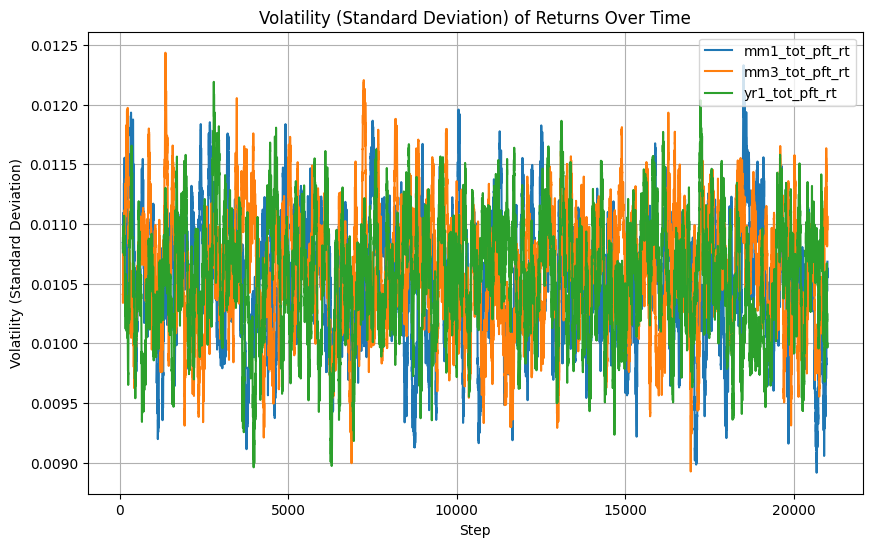

In [45]:
# 성과 지표 시각화 (1개월, 3개월, 1년 수익률)
# 변동성(표준 편차)을 시각화하기 위해 각 수익률의 표준 편차를 계산
volatility = portfolio_history_df[['mm1_tot_pft_rt', 'mm3_tot_pft_rt', 'yr1_tot_pft_rt']].rolling(window=100).std()

# 변동성을 시각화
volatility.plot(figsize=(10, 6))
plt.title('Volatility (Standard Deviation) of Returns Over Time')
plt.xlabel('Step')
plt.ylabel('Volatility (Standard Deviation)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

yr1_tot_pft_rt(1년 수익률)
:  가장 낮은 변동성으로, 장기적인 투자가 상대적으로 더 안정적이고 중요한 역할임을 알 수 있다

mm1_tot_pft_rt(1개월 수익률,3개월 수익률)
: 1년 수익률에 비해 높은 변동성을 보인다.

즉, 장기적으로 투자한 것이 더 안정적인 수익률을 보인다.

## 맞춤형 ETF 추천 모델 구축

In [43]:
# 필요한 컬럼만 추출해서 날짜를 기준으로 그룹화하여 평균 유입/유출 비율을 계산
ofw_info_filtered = NH_OFW_daily_info[['tck_iem_cd', 'bse_dt', 'ifw_ofw_amt_wht_rt']]
ofw_info_grouped = ofw_info_filtered.groupby(['tck_iem_cd', 'bse_dt']).mean().reset_index()

# 필요한 컬럼 추출해서 그룹화하여 평균 주가 및 수익률 계산
stock_daily_info_filtered = NH_Stock_daily_info[['tck_iem_cd', 'bse_dt', 'tot_hld_qty', 'tco_avg_pft_rt', 'bse_end_pr']]
stock_daily_info_grouped = stock_daily_info_filtered.groupby(['tck_iem_cd', 'bse_dt']).mean().reset_index()

# 필요한 컬럼만 추출해서 그룹화하여 평균 계좌수 비율 및 투자 비율 계산
# 리스트형 값이 있는지 확인하고 처리하는 함수
def remove_list_values(df, column_name):
    return df[column_name].apply(lambda x: x[0] if isinstance(x, list) else x)

# 리스트 값 제거 (필요한 컬럼에 적용)
customer_info_grouped['cus_cgr_llf_cd'] = remove_list_values(customer_info_grouped, 'cus_cgr_llf_cd')
customer_info_grouped['cus_cgr_mlf_cd'] = remove_list_values(customer_info_grouped, 'cus_cgr_mlf_cd')

# 고유값이 배열이 아닌 단일 값으로 나오는지 확인
unique_values = customer_info_grouped['cus_cgr_mlf_cd'].unique()

# 리스트형 값이 있는지 확인하고 단일 값으로 변환하는 함수
def convert_list_to_single_value(df, column_name):
    return df[column_name].apply(lambda x: x[0] if isinstance(x, list) else x)

# original_cus_cgr_llf_cd와 original_cus_cgr_mlf_cd 컬럼의 리스트 값을 제거하여 단일 값으로 변환
customer_info_grouped['original_cus_cgr_llf_cd'] = convert_list_to_single_value(customer_info_grouped, 'original_cus_cgr_llf_cd')
customer_info_grouped['original_cus_cgr_mlf_cd'] = convert_list_to_single_value(customer_info_grouped, 'original_cus_cgr_mlf_cd')

# 변환 후 결과 확인
print(customer_info_grouped[['original_cus_cgr_llf_cd', 'original_cus_cgr_mlf_cd']].head())

   original_cus_cgr_llf_cd  original_cus_cgr_mlf_cd
0                        2                       22
1                        1                       12
2                        3                       34
3                        1                       11
4                        2                       22


In [45]:
# 'etf_tck_cd_'로 시작하는 티커 컬럼만 선택
ticker_columns = [col for col in portfolio_history_df.columns if col.startswith('etf_tck_cd_')]

# 각 티커에 대해 성과 지표가 티커와 함께 병합되도록 유지
melted_portfolio_df = portfolio_history_df.melt(
    id_vars=['mm1_tot_pft_rt', 'mm3_tot_pft_rt', 'yr1_tot_pft_rt', 'etf_sor', 'etf_z_sor', 'z_sor_rnk', 
             'acl_pft_rt_z_sor', 'ifo_rt_z_sor', 'shpr_z_sor', 'crr_z_sor', 'trk_err_z_sor', 
             'mxdd_z_sor', 'vty_z_sor'],
    value_vars=ticker_columns,
    var_name='etf_tck_cd',
    value_name='portfolio_weight'
)

# 'etf_tck_cd' 컬럼에서 'etf_tck_cd_' 접두사를 제거
melted_portfolio_df['etf_tck_cd'] = melted_portfolio_df['etf_tck_cd'].str.replace('etf_tck_cd_', '')

# 성과 지표별로 데이터 유지
melted_portfolio_df = melted_portfolio_df.groupby(['etf_tck_cd', 'mm1_tot_pft_rt', 'mm3_tot_pft_rt', 'yr1_tot_pft_rt']).sum().reset_index()

# 최종 결과 확인
print(melted_portfolio_df.head())

  etf_tck_cd  mm1_tot_pft_rt  mm3_tot_pft_rt  yr1_tot_pft_rt   etf_sor  \
0       AWAY    8.206535e-07        0.032342        0.032370  0.009818   
1       AWAY    4.190992e-06        0.002139        0.022602  0.038297   
2       AWAY    6.204643e-06        0.028101        0.011306  0.030525   
3       AWAY    7.011086e-06        0.034772        0.022514  0.025834   
4       AWAY    8.160353e-06        0.012100        0.015273  0.013772   

   etf_z_sor  z_sor_rnk  acl_pft_rt_z_sor  ifo_rt_z_sor  shpr_z_sor  \
0   0.030722   0.025611          0.007976      0.015043    0.013996   
1   0.019842   0.013764          0.008915      0.002128    0.004515   
2   0.020417   0.022249          0.013834      0.019122    0.026531   
3   0.022528   0.000410          0.029706      0.009232    0.012050   
4   0.004352   0.020602          0.014298      0.032659    0.003327   

   crr_z_sor  trk_err_z_sor  mxdd_z_sor  vty_z_sor  portfolio_weight  
0   0.013721       0.021080    0.003332   0.021691       

In [46]:
# melted_portfolio_df의 투자 성과 지표 스케일링 적용 및 float32로 변환
scaler_portfolio = MinMaxScaler()
# 1개월, 3개월, 1년 수익률을 0~1 범위로 스케일링하고 float32 타입으로 변환
melted_portfolio_df[['mm1_tot_pft_rt', 'mm3_tot_pft_rt', 'yr1_tot_pft_rt']] = scaler_portfolio.fit_transform(
    melted_portfolio_df[['mm1_tot_pft_rt', 'mm3_tot_pft_rt', 'yr1_tot_pft_rt']]).astype(np.float32)

# customer_info_grouped의 투자 비율 스케일링 및 float32로 변환
scaler_customer = MinMaxScaler()
# 고객의 투자 비율(cus_cgr_ivs_rt)을 0~1로 스케일링하고 float32 타입으로 변환
customer_info_grouped['scaled_ivs_rt'] = scaler_customer.fit_transform(customer_info_grouped[['cus_cgr_ivs_rt']]).astype(np.float32)

# 원래의 cus_cgr_llf_cd와 cus_cgr_mlf_cd 컬럼 값을 따로 저장 (더미 변환 후 복원을 위함)
customer_info_grouped['original_cus_cgr_llf_cd'] = customer_info_grouped['cus_cgr_llf_cd']
customer_info_grouped['original_cus_cgr_mlf_cd'] = customer_info_grouped['cus_cgr_mlf_cd']

# cus_cgr_llf_cd, cus_cgr_mlf_cd 컬럼을 더미 변수로 변환하여 머신러닝 모델에 활용
customer_info_grouped = pd.get_dummies(customer_info_grouped, columns=['cus_cgr_llf_cd', 'cus_cgr_mlf_cd'], drop_first=True)

# 벡터화된 방식으로 고객군별로 ETF를 추천하는 최적화된 함수
def recommend_etf_optimized_vectorized(customer_data, portfolio_data, tolerance=0.05, weight_mm1=1.0, weight_mm3=1.0, weight_yr1=1.0):
    # 고객의 투자 비율 데이터를 열 형태로 변환
    customer_rates = customer_data['scaled_ivs_rt'].values.reshape(-1, 1)
    # 포트폴리오의 각 성과 지표를 변수로 할당
    mm1 = portfolio_data['mm1_tot_pft_rt'].values
    mm3 = portfolio_data['mm3_tot_pft_rt'].values
    yr1 = portfolio_data['yr1_tot_pft_rt'].values
    portfolio_weights = portfolio_data['portfolio_weight'].values
    etf_tickers = portfolio_data['etf_tck_cd'].values

    # 고객 투자 비율과 ETF 성과 지표 간의 차이를 계산하고 가중치를 적용
    # mm1, mm3, yr1은 각각 1개월, 3개월, 1년 수익률을 나타내며, 고객의 투자 비율(scaled_ivs_rt)과 비교하여 차이를 계산
    # 가중치(weight_mm1, weight_mm3, weight_yr1)를 적용하여 각 수익률 기간의 중요도를 반영
    # 즉, 어떤 수익률 기간을 더 중시할지에 따라 가중치를 달리하여 고객 맞춤형 ETF 추천을 가능하게 함
    # 예를 들어, 장기 투자를 선호하는 고객에게는 1년 수익률(yr1)에 더 높은 가중치를 부여할 수 있음
    diff_mm1 = np.abs(mm1 - customer_rates) * weight_mm1
    diff_mm3 = np.abs(mm3 - customer_rates) * weight_mm3
    diff_yr1 = np.abs(yr1 - customer_rates) * weight_yr1

    # 평균 차이를 구하여 추천을 위한 기준으로 사용
    avg_diff = (diff_mm1 + diff_mm3 + diff_yr1) / 3
    # 평균 차이가 특정 허용치 이하일 때 유효한 ETF로 간주
    mask = avg_diff <= tolerance

    recommended_etfs = []
    # 각 고객에 대해 조건을 만족하는 ETF를 추천
    for i in range(mask.shape[0]):
        valid_etfs = portfolio_data[mask[i]]
        # 조건을 만족하는 ETF 중 포트폴리오 비중이 가장 높은 것을 선택
        if not valid_etfs.empty:
            recommended_etf = valid_etfs.loc[valid_etfs['portfolio_weight'].idxmax()]['etf_tck_cd']
        else:
            # 조건을 만족하지 않는 경우, 차이가 가장 적은 ETF 중 무작위로 추천
            closest_etfs = np.argsort(avg_diff[i])[:3]
            recommended_etf = etf_tickers[np.random.choice(closest_etfs)]
        
        recommended_etfs.append(recommended_etf)

    return recommended_etfs

# 배치 처리 방식으로 고객군별로 ETF를 추천하는 함수
def recommend_etfs_in_batches(customer_data, portfolio_data, batch_size=500, tolerance=0.02, weight_mm1=1.0, weight_mm3=1.0, weight_yr1=1.0):
    num_rows = len(customer_data)
    num_batches = (num_rows + batch_size - 1) // batch_size
    all_recommended_etfs = []
    
    # 고객 데이터를 배치로 나누어 처리하여 추천 실행
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_rows)
        batch_data = customer_data.iloc[start_idx:end_idx]
        # 각 배치에 대해 추천 실행
        recommended_etfs = recommend_etf_optimized_vectorized(batch_data, portfolio_data, tolerance, weight_mm1, weight_mm3, weight_yr1)
        all_recommended_etfs.extend(recommended_etfs)
    
    return all_recommended_etfs

# 배치 크기 및 허용 오차 설정
batch_size = 200
tolerance = 0.05

# 배치 처리 방식으로 ETF 추천 실행
# 가중치 설정 : 1개월 수익률에 1배 중요도, 3개월 수익률에 1배 중요도, 1년 수익률에 2배 중요도 설정
customer_info_grouped['recommended_etf'] = recommend_etfs_in_batches(
    customer_info_grouped, melted_portfolio_df, batch_size, tolerance, weight_mm1=1.0, weight_mm3=1.0, weight_yr1=2.0
)

# 추천 결과 출력
print(customer_info_grouped[['tck_iem_cd', 'scaled_ivs_rt', 'recommended_etf']].head())

# 더미 변수로 변환된 'cus_cgr_llf_cd', 'cus_cgr_mlf_cd' 컬럼을 원래 값으로 복원
customer_info_grouped['cus_cgr_llf_cd'] = customer_info_grouped['original_cus_cgr_llf_cd']
customer_info_grouped['cus_cgr_mlf_cd'] = customer_info_grouped['original_cus_cgr_mlf_cd']

# 복원된 컬럼 확인
print(customer_info_grouped[['cus_cgr_llf_cd', 'cus_cgr_mlf_cd']].head())

     tck_iem_cd  scaled_ivs_rt recommended_etf
0  AAL                0.272376             VIG
1  AAL                0.272376             VIG
2  AAL                0.272376             VIG
3  AAL                0.272376             VIG
4  AAL                0.272376             VIG
   cus_cgr_llf_cd  cus_cgr_mlf_cd
0               2              22
1               1              12
2               3              34
3               1              11
4               2              22


맞춤형 ETF 추천 모델 알고리즘
1. 스케일링
   - 포트폴리오 성과 지표(1개월, 3개월, 1년 수익률)와 고객의 투자 비율을 MinMaxScaler로 0~1 범위로 변환하고,
   - 머신러닝 모델에 적합한 float32 타입으로 변환한다.

2. 더미 변수 변환
   - 고객의 투성향을 나타내는 cus_cgr_llf_cd 및 cus_cgr_mlf_cd 컬럼을 더미 변수로 변환
   - 변환 전 원래 값은 복원을 위해 따로 저장한다.
   
3. ETF 추천 알고리즘
   - 각 고객의 투자 비율과 ETF의 1개월, 3개월, 1년 수익률 간의 차이를 계산한다.
   - 고객의 투자 성향에 따라 각 수익률 기간에 가중치를 다르게 부여하여 고객에게 맞는 ETF를 추천
   - 가중치는 수익률 기간별로 달리 적용하여 장기 또는 단기 투자를 선호하는 고객에 맞는 추천을 가능하게 한다.
   - 1개월 수익률에 1배 중요도, 3개월 수익률에 1배 중요도, 1년 수익률에 2배 중요도 설정
   - 즉, 1년 수익률을 더 중요하게 반영한다.
   - 평균 차이가 허용 오차(tolerance) 이내일 때 가장 적합한 ETF를 선택

4. 고객별로 최종 추천된 ETF를 출력
더미 변수로 변환된 고객 투자 성향 데이터를 복원하여 원래의 형식으로 되돌린다.

In [72]:
# bool형 컬럼 필터링
bool_columns = customer_info_grouped.select_dtypes(include=['bool']).columns

# bool형 컬럼 드랍
customer_info_grouped = customer_info_grouped.drop(columns=bool_columns)

# 결과 확인
customer_info_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153907 entries, 0 to 593
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tck_iem_cd               153907 non-null  object 
 1   bse_dt                   153907 non-null  int64  
 2   cus_cgr_act_cnt_rt       153907 non-null  float64
 3   cus_cgr_ivs_rt           153907 non-null  float64
 4   scaled_ivs_rt            153907 non-null  float32
 5   original_cus_cgr_llf_cd  153907 non-null  int64  
 6   original_cus_cgr_mlf_cd  153907 non-null  int64  
 7   recommended_etf          153907 non-null  object 
 8   cus_cgr_llf_cd           153907 non-null  int64  
 9   cus_cgr_mlf_cd           153907 non-null  int64  
dtypes: float32(1), float64(2), int64(5), object(2)
memory usage: 12.3+ MB


In [73]:
customer_info_grouped.to_excel("customer_info_grouped_final.xlsx", index=False)

In [3]:
customer_info_grouped=pd.read_excel('customer_info_grouped_final.xlsx')

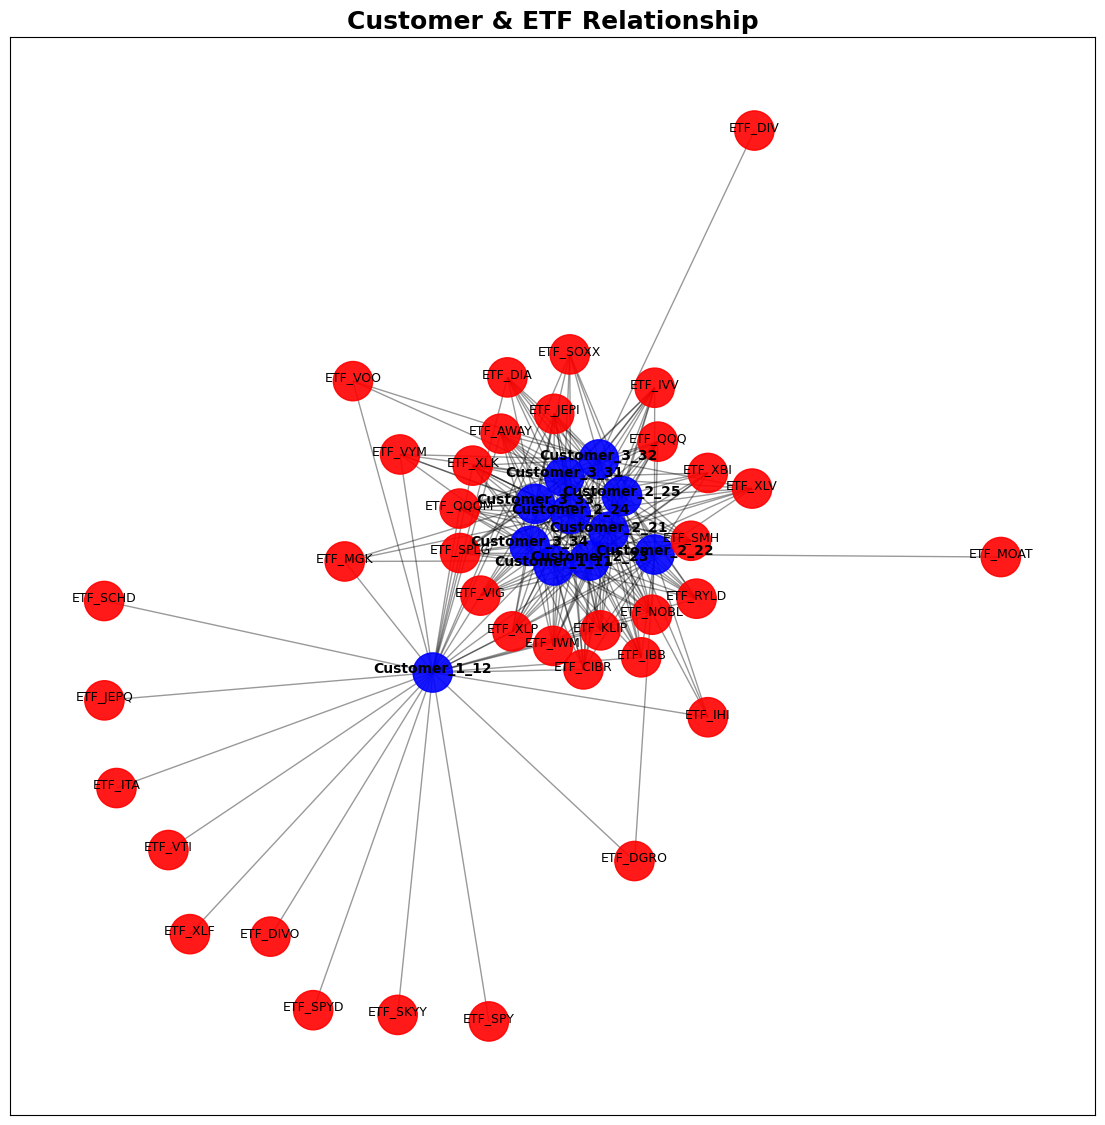

In [77]:
# 네트워크 그래프 생성
G = nx.Graph()

# 고객군과 ETF 관계 데이터 추가
for idx, row in customer_info_grouped.iterrows():
    customer_node = f"Customer_{row['cus_cgr_llf_cd']}_{row['cus_cgr_mlf_cd']}"
    etf_node = f"ETF_{row['recommended_etf']}"
    
    G.add_node(customer_node, type='customer')
    G.add_node(etf_node, type='etf')
    G.add_edge(customer_node, etf_node)

# 노드 그래프 
pos = nx.spring_layout(G, k=0.5, iterations=80)
node_color = ['blue' if G.nodes[node]['type'] == 'customer' else 'red' for node in G.nodes()]
plt.figure(figsize=(14, 14))  # 그래프 크기 확장
nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_color, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.4, width=1.0)
for node, (x, y) in pos.items():
    if G.nodes[node]['type'] == 'customer':
        plt.text(x, y, s=node, horizontalalignment='center', fontsize=10, fontweight='bold')
    else:
        plt.text(x, y, s=node, horizontalalignment='center', fontsize=9)

# 타이틀 추가
plt.title("Customer & ETF Relationship", size=18, fontweight='bold')

# 그래프 출력
plt.show()

#### 일반 투자자(Customer_1_12)들에게 특정 ETF(SCHD,JEPQ,ITA,VTI,XLF 등 초보자에게 자주 추천되어지는 etf)가 추천되었다
#### ETF: VIG, MOAT는 소수의 고객과 연결되어 있다

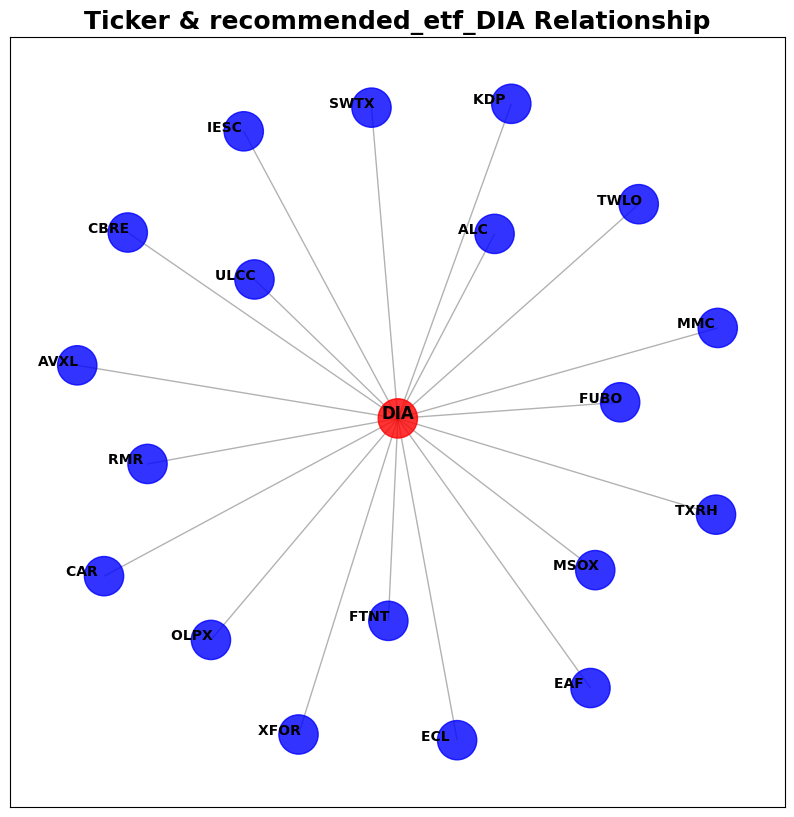

In [27]:
# 특정 ETF에 해당하는 티커만 필터링
specific_etf = "DIA"
filtered_data = customer_info_grouped[customer_info_grouped['recommended_etf'] == specific_etf]

# 네트워크 그래프 생성
G = nx.Graph()

# 필터링된 티커와 ETF 관계 데이터 추가
for idx, row in filtered_data.iterrows():
    ticker_node = f"Ticker_{row['tck_iem_cd']}"
    etf_node = f"ETF_{row['recommended_etf']}"
    
    G.add_node(ticker_node, type='ticker')
    G.add_node(etf_node, type='etf')
    G.add_edge(ticker_node, etf_node)

# 노드그래프
pos = nx.spring_layout(G, k=0.5, iterations=80)  # k 값을 조정하여 노드 간 거리 조정
node_color = ['blue' if G.nodes[node]['type'] == 'ticker' else 'red' for node in G.nodes()]
plt.figure(figsize=(10, 10))  # 그래프 크기 조정
nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_color, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3, width=1.0)
for node, (x, y) in pos.items():
    if G.nodes[node]['type'] == 'ticker':
        plt.text(x, y, s=node.replace("Ticker_", ""), horizontalalignment='center', fontsize=10, fontweight='bold')
    else:
        plt.text(x, y, s=node.replace("ETF_", ""), horizontalalignment='center', fontsize=12, fontweight='bold')

# 타이틀 추가
plt.title(f"Ticker & recommended_etf_{specific_etf} Relationship", size=18, fontweight='bold')

# 그래프 출력
plt.show()